# Grab-Microsoft Challenge 
## Traffic Management

- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
- day: the value indicates the sequential order and not a particular day of the month
- timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
- demand: aggregated demand normalised to be in the range [0,1]

## Problem Statements:
- Q1 Which areas have high / low traffic demand?
- Q2 How does regional traffic demand change according to day / time?
- Q3 Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

### Following data processing is as describe :
#### 1. Checking Datsete statistics
#### 2. Answering Q1 & Q2
#### 3. This is dataset features generation 


## Import python library

In [1]:
import pandas as pd   # for reading datasets
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler # for encoding geohash and data normalisation
import matplotlib.pyplot as plt # for Chart ploting

# to scale the data
from sklearn.preprocessing import StandardScaler
import joblib # for saving scaler

# For Clustering check
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import geohash as gh     # for geohash conversion
try:
    import _geohash
except ImportError:
    _geohash = None

### Define Function

In [2]:
#=========================================================================
# Function to Check on data spread and Normality
#=========================================================================

def Normality_Check(feature):
    
    subtitle = feature + ' Data'
    title1 = feature + " Count"
    title2 = feature + ' Spread'
    filename = 'diagram/' + feature + '_normality_check.png'
    
    # Ploting two figure side by side
    fig = plt.figure(figsize=(60,20)) #  figure
    fig.suptitle(subtitle, fontsize=40, fontweight='bold')
    ax1 = fig.add_subplot(121)
    
    ax1.set_title(title1, fontsize=30)
    ax1.xaxis.set_tick_params(labelsize=30)
    ax1.yaxis.set_tick_params(labelsize=30)
    ax2 = fig.add_subplot(122)
    
    ax2.set_title(title2, fontsize=30)
    ax2.xaxis.set_tick_params(labelsize=30)
    ax2.yaxis.set_tick_params(labelsize=30)

    plt.subplot(121) # 1st figure
    df[feature].hist(bins=50)

    plt.subplot(122) # 2nd figure
    df.boxplot(column=feature)
    # Save the chart to file
    plt.savefig(filename, bbox_inches="tight")


## 1. Reading from training dataset and checking Statistics

In [3]:
df = pd.read_csv("data/training.csv")
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:00,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:00,0.088755
4,qp090q,15,4:00,0.074468


- Read dataset metric data statistics
- Check for data integrity

In [4]:
# As can see from the summary, all the features has different range
df.describe(include='all')

,geohash6,day,timestamp,demand
count,1048575,1.048575e+06,1048575,1.048575e+06
unique,1314,NaN,96,NaN
top,qp03r3,NaN,9:00,NaN
freq,1534,NaN,14397,NaN
mean,NaN,3.146812e+01,NaN,1.048976e-01
std,NaN,1.767886e+01,NaN,1.588668e-01
min,NaN,1.000000e+00,NaN,3.040000e-08
25%,NaN,1.600000e+01,NaN,1.869865e-02
50%,NaN,3.200000e+01,NaN,5.046788e-02
75%,NaN,4.700000e+01,NaN,1.204841e-01


In [5]:
data_stats = df.describe()
data_stats = data_stats.transpose()
data_stats

,count,mean,std,min,25%,50%,75%,max
day,1048575.0,31.468115,17.678858,1.000000e+00,16.000000,32.000000,47.000000,61.0
demand,1048575.0,0.104898,0.158867,3.040000e-08,0.018699,0.050468,0.120484,1.0


In [6]:
demand_min = data_stats['min']['demand']
demand_max = data_stats['max']['demand']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   geohash6   1048575 non-null  object 
 1   day        1048575 non-null  int64  
 2   timestamp  1048575 non-null  object 
 3   demand     1048575 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [8]:
# check how many days of data
print("There are total {} days".format(len(df["day"].unique())))
np.sort(df["day"].unique())

There are total 61 days


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61], dtype=int64)

In [9]:
# check number of unique timestamp
print("There are total {} timestamp".format(len(df["timestamp"].unique())))
np.sort(df["timestamp"].unique())

There are total 96 timestamp


array(['0:00', '0:15', '0:30', '0:45', '10:00', '10:15', '10:30', '10:45',
       '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30',
       '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15',
       '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00',
       '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45',
       '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30',
       '19:45', '1:00', '1:15', '1:30', '1:45', '20:00', '20:15', '20:30',
       '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15',
       '22:30', '22:45', '23:00', '23:15', '23:30', '23:45', '2:00',
       '2:15', '2:30', '2:45', '3:00', '3:15', '3:30', '3:45', '4:00',
       '4:15', '4:30', '4:45', '5:00', '5:15', '5:30', '5:45', '6:00',
       '6:15', '6:30', '6:45', '7:00', '7:15', '7:30', '7:45', '8:00',
       '8:15', '8:30', '8:45', '9:00', '9:15', '9:30', '9:45'],
      dtype=object)

## 2a. Which areas have high / low traffic demand?

In [10]:
highest_demand_area = df[df['demand']== demand_max]
highest_demand_area

,geohash6,day,timestamp,demand
96,qp09e5,27,11:30,1.0
132,qp098j,60,11:30,1.0
453,qp03xx,34,10:00,1.0
509,qp03yb,2,9:15,1.0
770,qp096v,39,16:30,1.0
...,...,...,...,...
1047906,qp096q,39,2:30,1.0
1047977,qp09d3,1,13:30,1.0
1048395,qp09e5,45,15:30,1.0
1048404,qp096x,46,11:15,1.0


In [11]:
lowest_demand_area = df[df['demand']== demand_min]
lowest_demand_area

,geohash6,day,timestamp,demand
743542,qp0d4t,41,18:30,3.040000e-08


In [12]:
gh.decode('qp0d4t')

(-5.24322509765625, 90.8184814453125)

In [13]:
# In order to know visually which area is in high demand need to know the unque geohash has 
# the higher numbers of count
geohashes_High_demand = highest_demand_area.groupby("geohash6", as_index=False)\
.agg({"day":"count"})\
.rename(columns={"day":"count"})\
.sort_values(by="count", ascending=False)

In [14]:
geohashes_High_demand

,geohash6,count
69,qp09d9,925
73,qp09e5,843
34,qp03xx,769
33,qp03xw,703
36,qp03yb,530
...,...,...
14,qp03r0,1
12,qp03qm,1
11,qp03qj,1
7,qp03p7,1


In [15]:
geohashes_High_demand[['lat','long']] = geohashes_High_demand['geohash6'].apply(lambda x: pd.Series(gh.decode(x)))
geohashes_High_demand

,geohash6,count,lat,long
69,qp09d9,925,-5.353088,90.818481
73,qp09e5,843,-5.342102,90.840454
34,qp03xx,769,-5.320129,90.686646
33,qp03xw,703,-5.325623,90.686646
36,qp03yb,530,-5.314636,90.653687
...,...,...,...,...
14,qp03r0,1,-5.402527,90.664673
12,qp03qm,1,-5.375061,90.631714
11,qp03qj,1,-5.375061,90.620728
7,qp03p7,1,-5.429993,90.675659


### Create geohash cluster

In [16]:
# For proper clustering , is best to convert the lat and long data to standard scaling
# Create a temp lat-long data for clustering check
latlong_H = geohashes_High_demand[["lat", "long"]].values
latlong_H = np.nan_to_num(latlong_H) # In case any too small or large number generated
latlong_H = StandardScaler().fit_transform(latlong_H)

print(latlong_H.shape)
latlong_H

(83, 2)


array([[ 0.03465922,  1.0873075 ],
       [ 0.27438547,  1.35629862],
       [ 0.75383797, -0.52663925],
       [ 0.63397484, -0.52663925],
       [ 0.8737011 , -0.93012594],
       [-0.08520391,  0.95281193],
       [ 0.75383797, -0.93012594],
       [ 0.63397484,  1.49079418],
       [ 0.15452234, -0.93012594],
       [-0.32493016,  0.95281193],
       [-2.24274017, -0.52663925],
       [ 0.03465922,  1.22180306],
       [ 0.03465922, -1.0646215 ],
       [ 1.59287985,  2.29776756],
       [-0.20506703,  1.22180306],
       [-0.20506703,  1.0873075 ],
       [ 0.51411172, -0.66113481],
       [-2.12287704, -0.39214369],
       [ 0.03465922,  0.95281193],
       [-0.20506703,  0.95281193],
       [-0.08520391,  1.0873075 ],
       [-0.44479329,  1.22180306],
       [ 0.8737011 , -0.66113481],
       [-0.68451954, -0.93012594],
       [ 1.47301672,  1.0873075 ],
       [ 0.15452234, -1.0646215 ],
       [ 0.51411172, -0.25764813],
       [ 0.27438547, -0.93012594],
       [ 0.27438547,

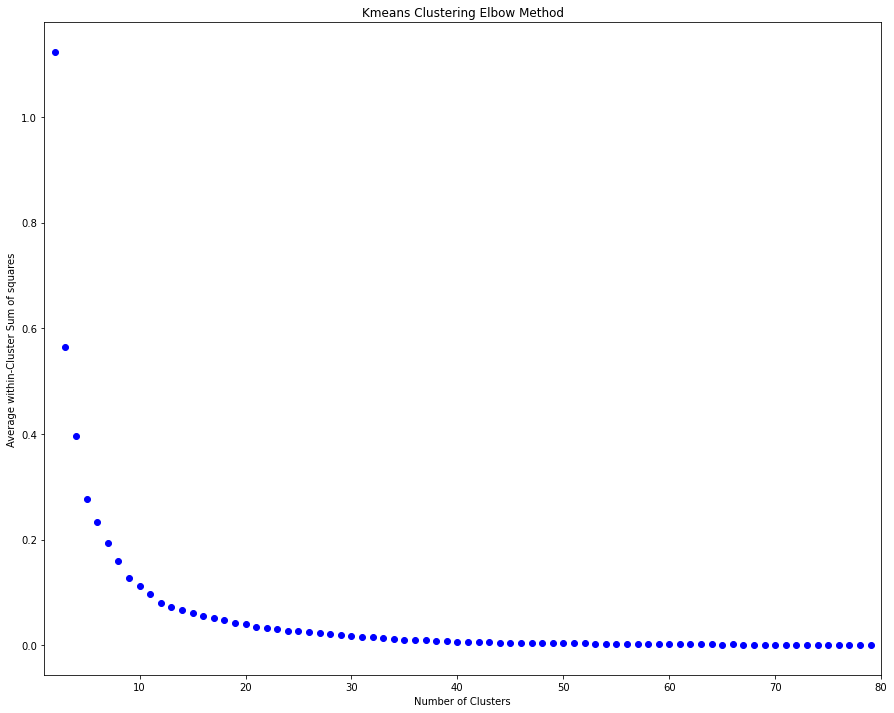

In [17]:
# KMeans Elbow method

A = []
B = []

for i in range (2 , 80):
    # fit a Kmeans model to the data
    model = KMeans(init='k-means++',n_clusters=i, n_init=10)
    model.fit(latlong_H)
    
    # Append number of cluster to A data list
    A.append(i)
    
    # Append average within cluster sum of squares to B data List
    SSE = model.inertia_/ latlong_H.shape[0]
    B.append(SSE)

# plot A & B
plt.figure(figsize=(15,12))
plt.plot(A,B,'bo')
plt.xlim((1,80))
plt.xlabel('Number of Clusters')
plt.ylabel('Average within-Cluster Sum of squares')
plt.title('Kmeans Clustering Elbow Method')

# Display the plot
plt.show()

**Note:** Since the tapping off is around 50 to 60, I will choose k=50 to cluster the locations

In [18]:
# fit a Kmeans model to the data
KMeans_model_H = KMeans(init='k-means++',n_clusters=50, n_init=10)
KMeans_model_H.fit(latlong_H)
cluster_centers = KMeans_model_H.cluster_centers_
labels_H = KMeans_model_H.labels_
print(KMeans_model_H)

KMeans(n_clusters=50)


In [19]:
np.unique(labels_H)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [20]:
# assign the labels back to the dataset
geohashes_High_demand["geo_cluster"] = labels_H
geohashes_High_demand

,geohash6,count,lat,long,geo_cluster
69,qp09d9,925,-5.353088,90.818481,49
73,qp09e5,843,-5.342102,90.840454,23
34,qp03xx,769,-5.320129,90.686646,1
33,qp03xw,703,-5.325623,90.686646,1
36,qp03yb,530,-5.314636,90.653687,18
...,...,...,...,...,...
14,qp03r0,1,-5.402527,90.664673,44
12,qp03qm,1,-5.375061,90.631714,31
11,qp03qj,1,-5.375061,90.620728,31
7,qp03p7,1,-5.429993,90.675659,2


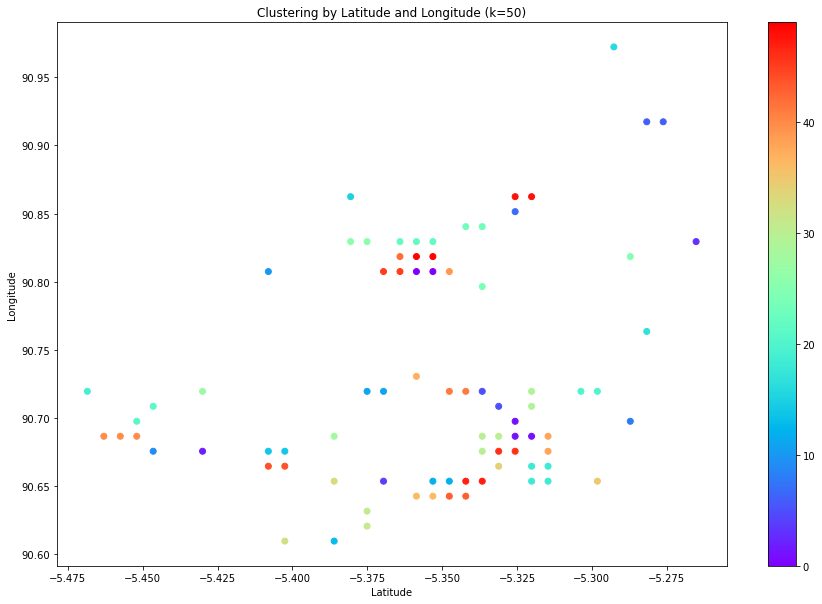

In [21]:
# Visualisation of the cluster labels
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(geohashes_High_demand["lat"], geohashes_High_demand["long"], c=geohashes_High_demand["geo_cluster"], cmap="rainbow")
plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Clustering by Latitude and Longitude (k=50)")
plt.savefig("geohash_High_demand_clustering.png", bbox_inches="tight")
plt.show()

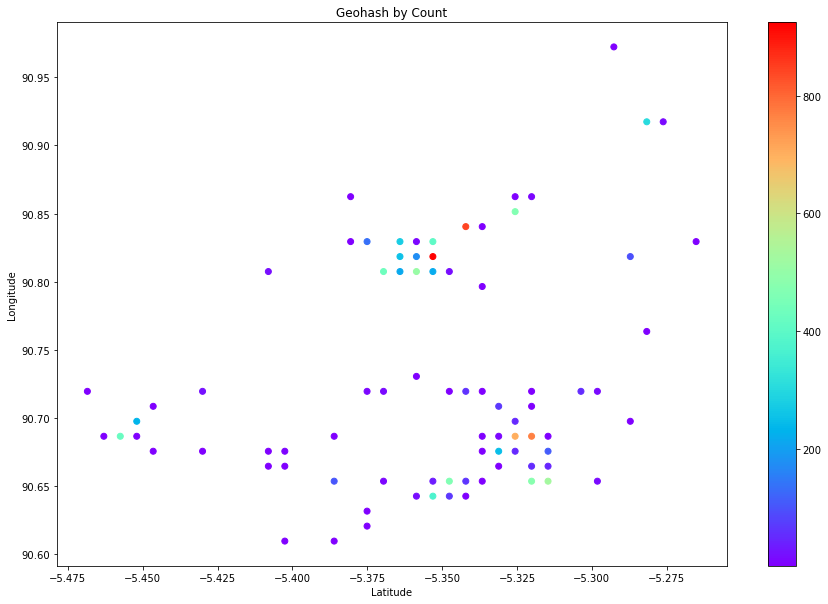

In [22]:
# Visualisation of the geohash count labels
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(geohashes_High_demand["lat"], geohashes_High_demand["long"], c=geohashes_High_demand["count"], cmap="rainbow")
plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Geohash by Count")
plt.savefig("geohash__High_demand_Count_clustering.png", bbox_inches="tight")
plt.show()

- As reference to the data and visualisation above the using max count and highest demand = 1,  latlong(-5.353088,90.818481)
- is the area having the highest traffic
- Lowest demand area is latlong(-5.24322509765625, 90.8184814453125)

### Checking on the geohash area distribution count

In [23]:
# In order to know visually which area in terms of count in each unque geohash has 
geohashes_group = df.groupby("geohash6", as_index=False)\
.agg({"day":"count"})\
.rename(columns={"day":"count"})\
.sort_values(by="count", ascending=False)

In [24]:
geohashes_group

,geohash6,count
141,qp03r3,1534
631,qp096t,1530
502,qp092m,1526
637,qp096z,1523
628,qp096q,1515
...,...,...
1247,qp0d5n,1
825,qp09eg,1
966,qp09kg,1
1002,qp09mv,1


In [25]:
geohashes_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1314 entries, 141 to 984
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   geohash6  1314 non-null   object
 1   count     1314 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.8+ KB


In [26]:
geohashes_group[['lat','long']] = geohashes_group['geohash6'].apply(lambda x: pd.Series(gh.decode(x)))
geohashes_group

,geohash6,count,lat,long
141,qp03r3,1534,-5.397034,90.675659
631,qp096t,1530,-5.375061,90.818481
502,qp092m,1526,-5.375061,90.719604
637,qp096z,1523,-5.364075,90.829468
628,qp096q,1515,-5.369568,90.807495
...,...,...,...,...
1247,qp0d5n,1,-5.237732,90.840454
825,qp09eg,1,-5.342102,90.873413
966,qp09kg,1,-5.386047,90.917358
1002,qp09mv,1,-5.375061,90.961304


#### Create geohash cluster

In [27]:
# For proper clustering , is best to convert the lat and long data to standard scaling
# Create a temp lat-long data for clustering check
latlong = geohashes_group[["lat", "long"]].values
latlong = np.nan_to_num(latlong) # In case any too small or large number generated
latlong = StandardScaler().fit_transform(latlong)

print(latlong.shape)
latlong

(1314, 2)


array([[-0.70650955, -1.03046278],
       [-0.37229893,  0.30123378],
       [-0.37229893, -0.62070999],
       ...,
       [-0.53940424,  1.22317756],
       [-0.37229893,  1.63293034],
       [-0.62295689,  1.42805395]])

- use two methods to check for clustering
  - Silhouette Coefficient
  - KMeans Elbow method

In [28]:
# Silhouette Coefficient: Combines both the Cohesion and Separation
score = []
results = []
values = np.arange(2, 80)

for n_cluster in values:
    kmeans = KMeans(n_clusters=n_cluster).fit(latlong)
    label = kmeans.labels_
    # get inertia
    inertia = kmeans.inertia_
    sil_coeff = silhouette_score(latlong, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    score.append(sil_coeff)
    # add results to list
    results.append({'n':n_cluster, 'sil_coef':sil_coeff, 'inertia':inertia})

For n_clusters=2, The Silhouette Coefficient is 0.3525714252646768
For n_clusters=3, The Silhouette Coefficient is 0.3886806638394898
For n_clusters=4, The Silhouette Coefficient is 0.3905794289993799
For n_clusters=5, The Silhouette Coefficient is 0.3690495568907571
For n_clusters=6, The Silhouette Coefficient is 0.38631952437356604
For n_clusters=7, The Silhouette Coefficient is 0.38608071340187317
For n_clusters=8, The Silhouette Coefficient is 0.37221085901433315
For n_clusters=9, The Silhouette Coefficient is 0.3673119731863732
For n_clusters=10, The Silhouette Coefficient is 0.36117971608841204
For n_clusters=11, The Silhouette Coefficient is 0.36153731611015794
For n_clusters=12, The Silhouette Coefficient is 0.36516914437737724
For n_clusters=13, The Silhouette Coefficient is 0.36460713652641746
For n_clusters=14, The Silhouette Coefficient is 0.35958632060409124
For n_clusters=15, The Silhouette Coefficient is 0.3539250429598515
For n_clusters=16, The Silhouette Coefficient is

Text(0.5, 1.0, 'Silhouette score vs number of clusters')

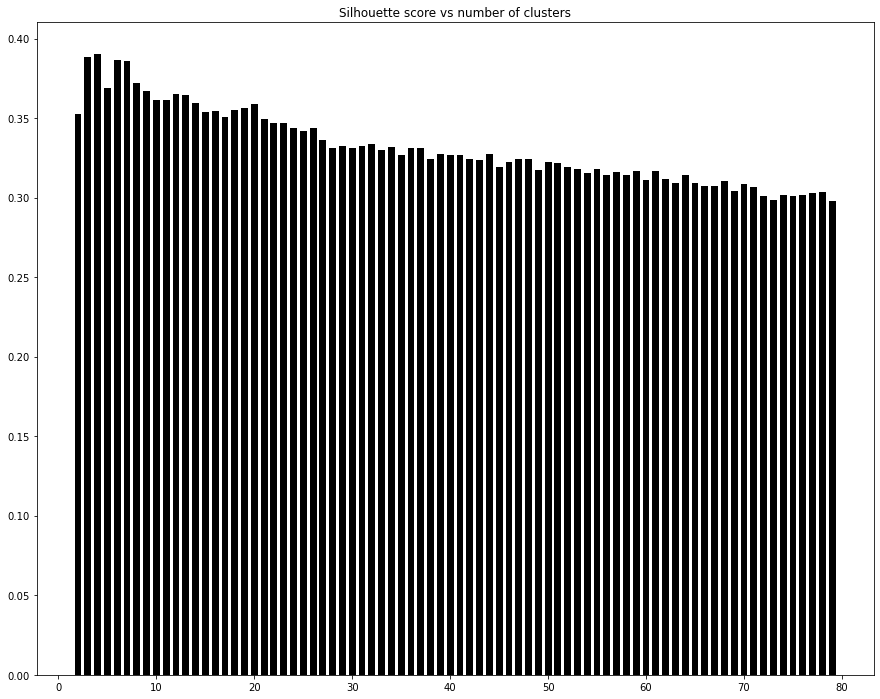

In [29]:
# Visualize the silhouette scores for various values:
# Plot silhouette scores

plt.figure(figsize=(15,12))
plt.bar(values, score, width=0.7, color='black', align='center')
plt.title('Silhouette score vs number of clusters')

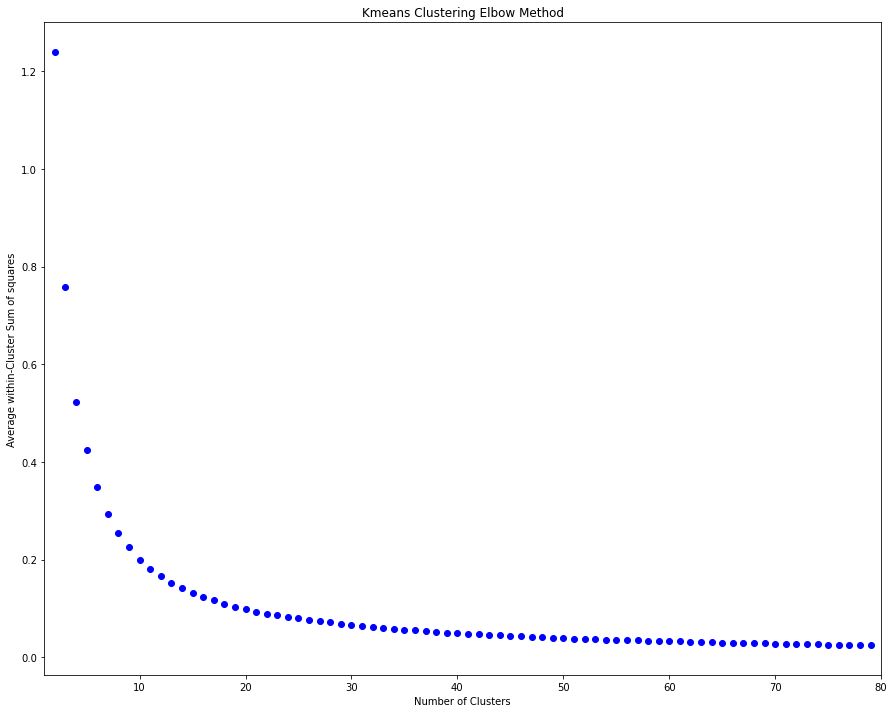

In [30]:
# KMeans Elbow method

A = []
B = []

for i in range (2 , 80):
    # fit a Kmeans model to the data
    model = KMeans(init='k-means++',n_clusters=i, n_init=10)
    model.fit(latlong)
    
    # Append number of cluster to A data list
    A.append(i)
    
    # Append average within cluster sum of squares to B data List
    SSE = model.inertia_/ latlong.shape[0]
    B.append(SSE)

# plot A & B
plt.figure(figsize=(15,12))
plt.plot(A,B,'bo')
plt.xlim((1,80))
plt.xlabel('Number of Clusters')
plt.ylabel('Average within-Cluster Sum of squares')
plt.title('Kmeans Clustering Elbow Method')

# Display the plot
plt.show()

**Note:** Since the tapping off is around 50 to 60, I will choose k=50 to cluster the locations

In [31]:
# fit a Kmeans model to the data
KMeans_model = KMeans(init='k-means++',n_clusters=50, n_init=10)
KMeans_model.fit(latlong)
cluster_centers = KMeans_model.cluster_centers_
labels = KMeans_model.labels_
print(KMeans_model)

KMeans(n_clusters=50)


In [32]:
labels

array([ 0, 24, 28, ..., 30, 25,  7])

In [33]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [34]:
# assign the labels back to the dataset
geohashes_group["geo_cluster"] = labels

In [35]:
geohashes_group.head(12)

,geohash6,count,lat,long,geo_cluster
141,qp03r3,1534,-5.397034,90.675659,0
631,qp096t,1530,-5.375061,90.818481,24
502,qp092m,1526,-5.375061,90.719604,28
637,qp096z,1523,-5.364075,90.829468,48
628,qp096q,1515,-5.369568,90.807495,48
815,qp09e5,1515,-5.342102,90.840454,22
865,qp09ft,1511,-5.287170,90.818481,10
144,qp03r6,1511,-5.391541,90.675659,15
247,qp03xf,1510,-5.347595,90.697632,41
675,qp0985,1509,-5.342102,90.708618,41


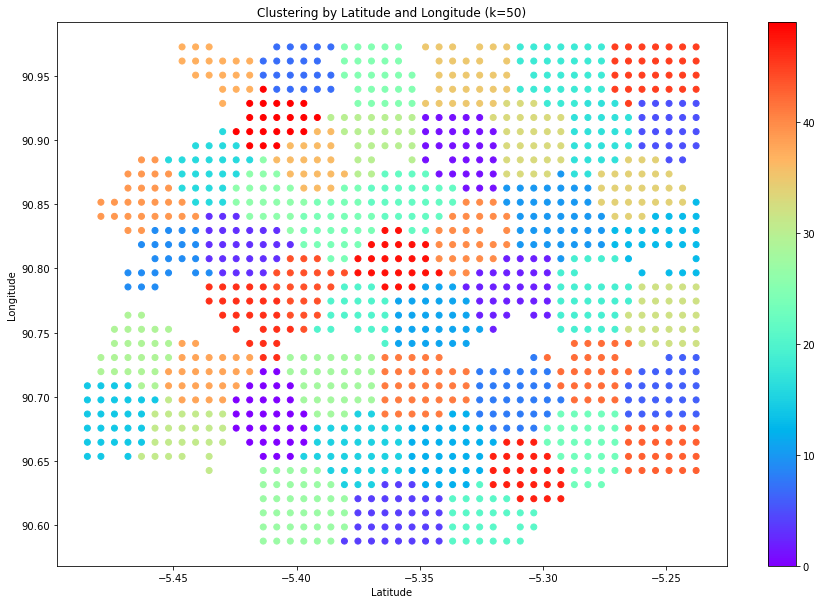

In [36]:
# Visualisation of the cluster labels
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(geohashes_group["lat"], geohashes_group["long"], c=geohashes_group["geo_cluster"], cmap="rainbow")
plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Clustering by Latitude and Longitude (k=50)")
plt.savefig("geohash_region_clustering.png", bbox_inches="tight")
plt.show()

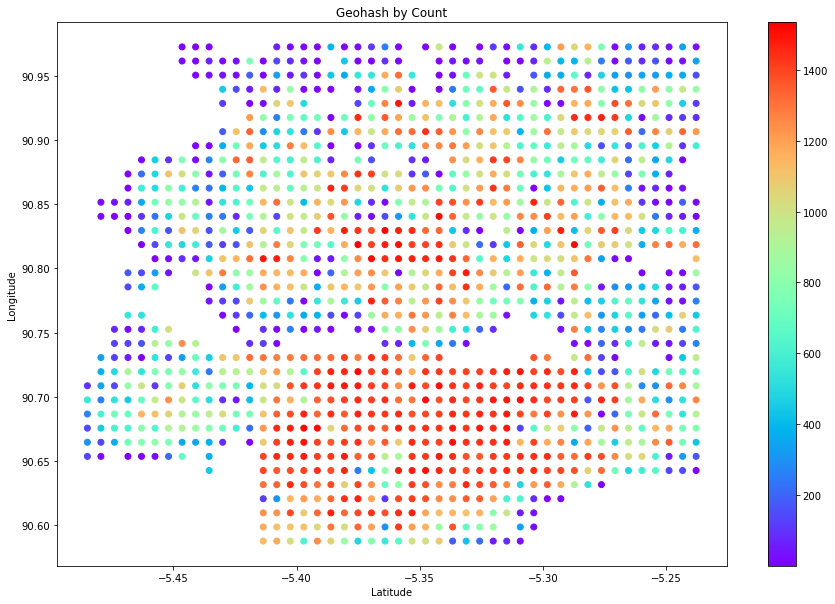

In [37]:
# Visualisation of the geohash count labels
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(geohashes_group["lat"], geohashes_group["long"], c=geohashes_group["count"], cmap="rainbow")
plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Geohash by Count")
plt.savefig("geohash_Count_clustering.png", bbox_inches="tight")
plt.show()

- Q2 : Which areas have high / low traffic demand?
- Seems like the most geohash counts are:
    - between latitude -5.4 to -5.3 
    - between longitude 90.6 to 90.75
    - Does that means more count = to more demand ?
    - with the evidence from the sort by lowest demand value that some coninsides with lowest count the same area 
    - (-5.24322509765625, 90.8184814453125)
    - with the evidence from the sort by highest demand value that some coninsides with highest count the same area 
    - (-5.353088,90.818481)

### Feature Engineering for the DNN Model

#### Extract hour and minute from timestamp column and Day of Week (dow)

In [39]:
# Extract hour and min from timestamp
df[['hour','min']] = df['timestamp'].str.split(':',expand=True)
df['hour'] = df['hour'].astype('int64')
df['min'] = df['min'].astype('int64')

# extract day of week (DoW) from day
df['dow'] = df['day'] % (7)

#### Convert geohash to Lat & long

In [40]:
df[['lat','long']] = df['geohash6'].apply(lambda x: pd.Series(gh.decode(x)))
df.head(30)


,geohash6,day,timestamp,demand,hour,min,dow,lat,long
0,qp03wc,18,20:00,0.020072,20,0,4,-5.353088,90.653687
1,qp03pn,10,14:30,0.024721,14,30,3,-5.413513,90.664673
2,qp09sw,9,6:15,0.102821,6,15,2,-5.325623,90.906372
3,qp0991,32,5:00,0.088755,5,0,4,-5.353088,90.752563
4,qp090q,15,4:00,0.074468,4,0,1,-5.413513,90.719604
5,qp03tu,1,12:15,0.023843,12,15,1,-5.336609,90.609741
6,qp096d,25,3:30,0.007460,3,30,4,-5.391541,90.818481
7,qp03nr,51,20:45,0.000293,20,45,2,-5.408020,90.631714
8,qp093r,48,6:15,0.054170,6,15,6,-5.364075,90.763550
9,qp03r2,4,22:15,0.123463,22,15,4,-5.402527,90.675659


In [41]:
df.info

<bound method DataFrame.info of         geohash6  day timestamp    demand  hour  min  dow       lat       long
0         qp03wc   18     20:00  0.020072    20    0    4 -5.353088  90.653687
1         qp03pn   10     14:30  0.024721    14   30    3 -5.413513  90.664673
2         qp09sw    9      6:15  0.102821     6   15    2 -5.325623  90.906372
3         qp0991   32      5:00  0.088755     5    0    4 -5.353088  90.752563
4         qp090q   15      4:00  0.074468     4    0    1 -5.413513  90.719604
...          ...  ...       ...       ...   ...  ...  ...       ...        ...
1048570   qp0dh4    6      8:30  0.024022     8   30    6 -5.259705  90.884399
1048571   qp08by   23     15:30  0.005703    15   30    2 -5.457458  90.741577
1048572   qp03x1   42     15:45  0.067131    15   45    0 -5.353088  90.664673
1048573   qp09f9    2      6:30  0.151323     6   30    2 -5.309143  90.818481
1048574   qp09u2    5     10:45  0.026007    10   45    5 -5.314636  90.895386

[1048575 rows x 9 c

## 2b. How does regional traffic demand change according to day / time?
### Check on the day pattern


In [42]:
gh.decode('qp03wz')

(-5.32012939453125, 90.6536865234375)

In [43]:
dq = df[df['geohash6']=='qp03wz'].sort_values(by=['day','min'])

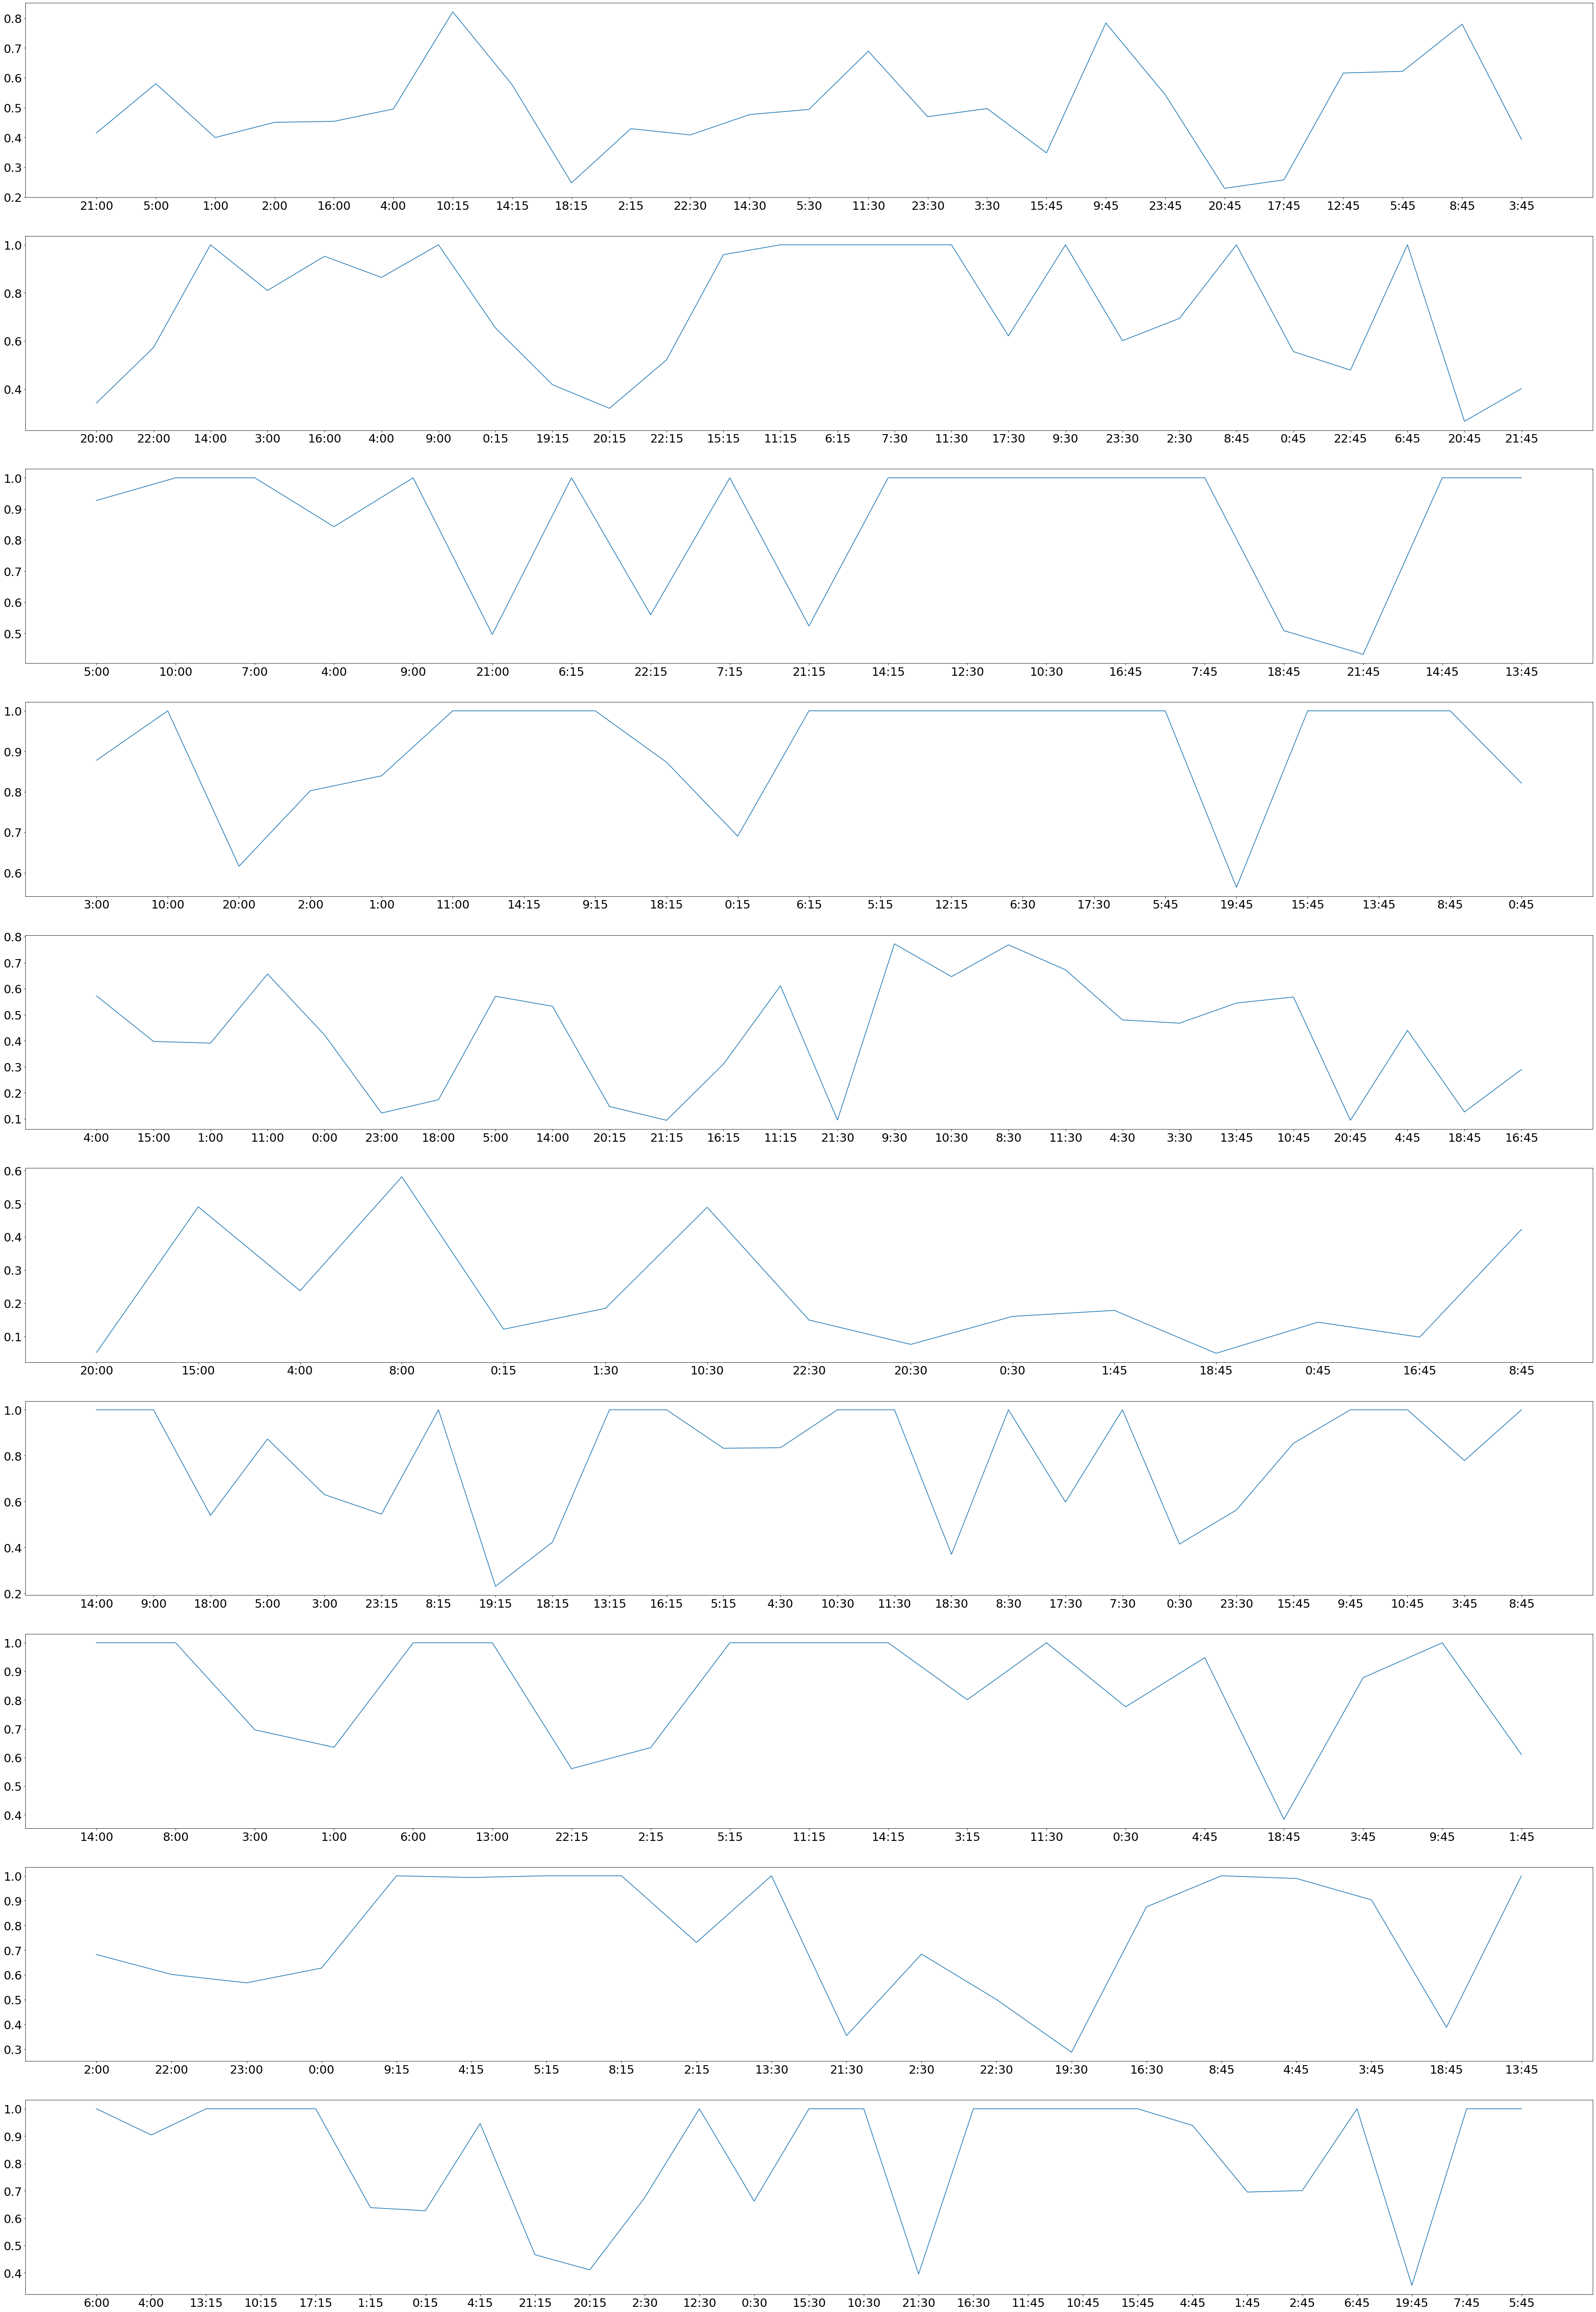

In [46]:
FIG_NUM = 10

fig = plt.figure(figsize=(60,90))

axs = fig.subplots(FIG_NUM)

for i in range(0,FIG_NUM):
    temp_dq = dq[dq['day']==i+1]
    x = temp_dq['timestamp']
    y = temp_dq['demand']
    axs[i].tick_params(axis="x", labelsize=25)
    axs[i].tick_params(axis="y", labelsize=25)
    axs[i].plot(x,y)


From the chart above, high demands appear as majority around working hours. We can conclude that this is likely CBD area 
without evening entertainment. we see 5 days of peak demand and weekend of low demand, with some public holiday in between. 
we can conclude that 1st day is a tuesday, 2nd day is wednesday and etc. 
If monday is coded as 1, the algo to encode weeday will be (day mod 7 +1), e.g. 1 mod 7 +1 =2, which is tuesday

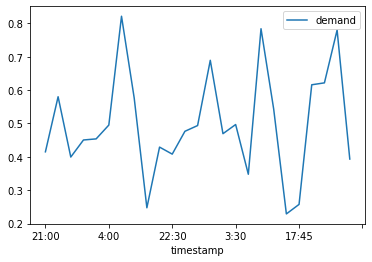

In [47]:
dq[dq['day']==1].plot(y='demand', x='timestamp')

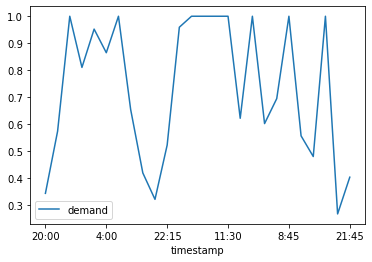

In [48]:
dq[dq['day']==2].plot(y='demand', x='timestamp')

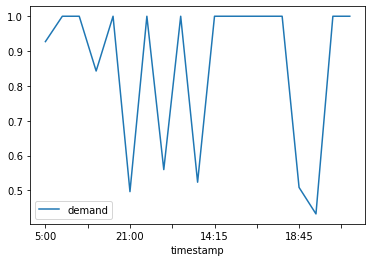

In [49]:
dq[dq['day']==3].plot(y='demand', x='timestamp')

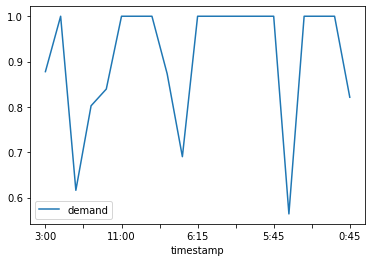

In [50]:
dq[dq['day']==4].plot(y='demand', x='timestamp')

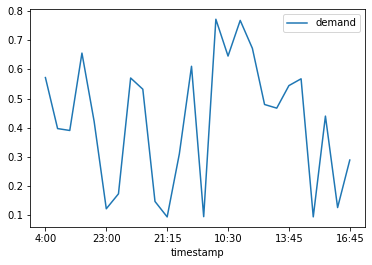

In [51]:
dq[dq['day']==5].plot(y='demand', x='timestamp')

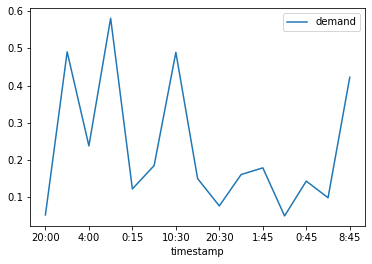

In [52]:
dq[dq['day']==6].plot(y='demand', x='timestamp')

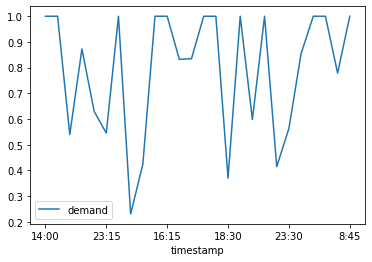

In [53]:
dq[dq['day']==7].plot(y='demand', x='timestamp')

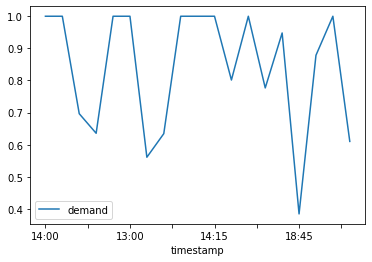

In [54]:
dq[dq['day']==8].plot(y='demand', x='timestamp')

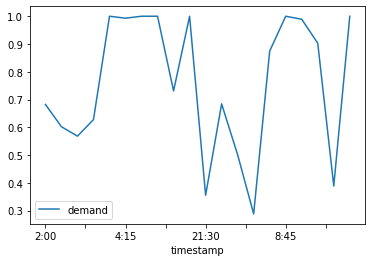

In [55]:
dq[dq['day']==9].plot(y='demand', x='timestamp')

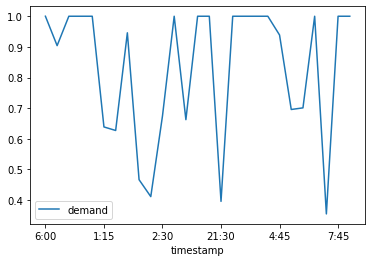

In [56]:
dq[dq['day']==10].plot(y='demand', x='timestamp')

#### Extract hour and minute from timestamp column and Day of Week (dow) with 7+1

In [57]:
# Extract hour and min from timestamp
df[['hour','min']] = df['timestamp'].str.split(':',expand=True)
df['hour'] = df['hour'].astype('int64')
df['min'] = df['min'].astype('int64')

# extract day of week (DoW) from day
df['dow'] = df['day'] % (7+1)

In [58]:
df[['lat','long']] = df['geohash6'].apply(lambda x: pd.Series(gh.decode(x)))
df.head(30)

,geohash6,day,timestamp,demand,hour,min,dow,lat,long
0,qp03wc,18,20:00,0.020072,20,0,2,-5.353088,90.653687
1,qp03pn,10,14:30,0.024721,14,30,2,-5.413513,90.664673
2,qp09sw,9,6:15,0.102821,6,15,1,-5.325623,90.906372
3,qp0991,32,5:00,0.088755,5,0,0,-5.353088,90.752563
4,qp090q,15,4:00,0.074468,4,0,7,-5.413513,90.719604
5,qp03tu,1,12:15,0.023843,12,15,1,-5.336609,90.609741
6,qp096d,25,3:30,0.007460,3,30,1,-5.391541,90.818481
7,qp03nr,51,20:45,0.000293,20,45,3,-5.408020,90.631714
8,qp093r,48,6:15,0.054170,6,15,0,-5.364075,90.763550
9,qp03r2,4,22:15,0.123463,22,15,4,-5.402527,90.675659


## 3. Dataset features generations

#### Drop unused features

In [59]:
# Drop original column timestamp and geohash
# Since we have already converted both timestamp and geohash into more detail features
df = df.sort_values(['geohash6','day','hour','min']).reset_index(drop=True)
df.drop(columns=['geohash6', 'timestamp'], inplace=True)
df = df[['day', 'hour', 'min', 'dow', 'lat', 'long','demand']]

df.head(30)

,day,hour,min,dow,lat,long,demand
0,2,4,30,2,-5.484924,90.653687,0.011041
1,2,22,45,2,-5.484924,90.653687,0.031419
2,4,4,30,4,-5.484924,90.653687,0.057966
3,4,6,0,4,-5.484924,90.653687,0.044834
4,4,6,30,4,-5.484924,90.653687,0.007841
5,4,10,15,4,-5.484924,90.653687,0.014625
6,4,11,30,4,-5.484924,90.653687,0.007581
7,4,13,0,4,-5.484924,90.653687,0.005394
8,5,5,0,5,-5.484924,90.653687,0.004341
9,5,8,15,5,-5.484924,90.653687,0.007418


#### Save sample for testing later

In [60]:
start_sample = 8000
end_sample   = 8023
test_sample  = df[start_sample:end_sample]
test_sample

,day,hour,min,dow,lat,long,demand
8000,39,0,30,7,-5.462952,90.675659,0.015639
8001,39,2,0,7,-5.462952,90.675659,0.056111
8002,39,3,45,7,-5.462952,90.675659,0.044882
8003,39,4,0,7,-5.462952,90.675659,0.068662
8004,39,4,15,7,-5.462952,90.675659,0.044240
8005,39,5,45,7,-5.462952,90.675659,0.091001
8006,39,6,30,7,-5.462952,90.675659,0.018806
8007,39,8,30,7,-5.462952,90.675659,0.061479
8008,39,10,15,7,-5.462952,90.675659,0.124647
8009,39,10,45,7,-5.462952,90.675659,0.115308


In [61]:
writer = pd.ExcelWriter('data/test_sorted_sample8000.xlsx', engine='xlsxwriter')
test_sample.to_excel(writer, sheet_name='TrafficMgmt', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

#### normalize features

In [62]:
y = df['demand']
scaler = MinMaxScaler(feature_range=(0, 1))
df[['day','hour','min','dow','lat','long']] = scaler.fit_transform(df[['day','hour','min','dow','lat','long']])

In [63]:
scaler_filename = "grab_msft_scaler.save"
joblib.dump(scaler, scaler_filename) 

['grab_msft_scaler.save']

In [64]:
df

,day,hour,min,dow,lat,long,demand
0,0.016667,0.173913,0.666667,0.285714,0.0,0.171429,0.011041
1,0.016667,0.956522,1.000000,0.285714,0.0,0.171429,0.031419
2,0.050000,0.173913,0.666667,0.571429,0.0,0.171429,0.057966
3,0.050000,0.260870,0.000000,0.571429,0.0,0.171429,0.044834
4,0.050000,0.260870,0.666667,0.571429,0.0,0.171429,0.007841
...,...,...,...,...,...,...,...
1048570,0.683333,0.347826,0.000000,0.285714,1.0,1.000000,0.004793
1048571,0.916667,0.434783,0.333333,0.000000,1.0,1.000000,0.016509
1048572,0.933333,0.434783,0.000000,0.142857,1.0,1.000000,0.015804
1048573,0.966667,0.391304,0.666667,0.428571,1.0,1.000000,0.012543


#### Check for data Normality

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


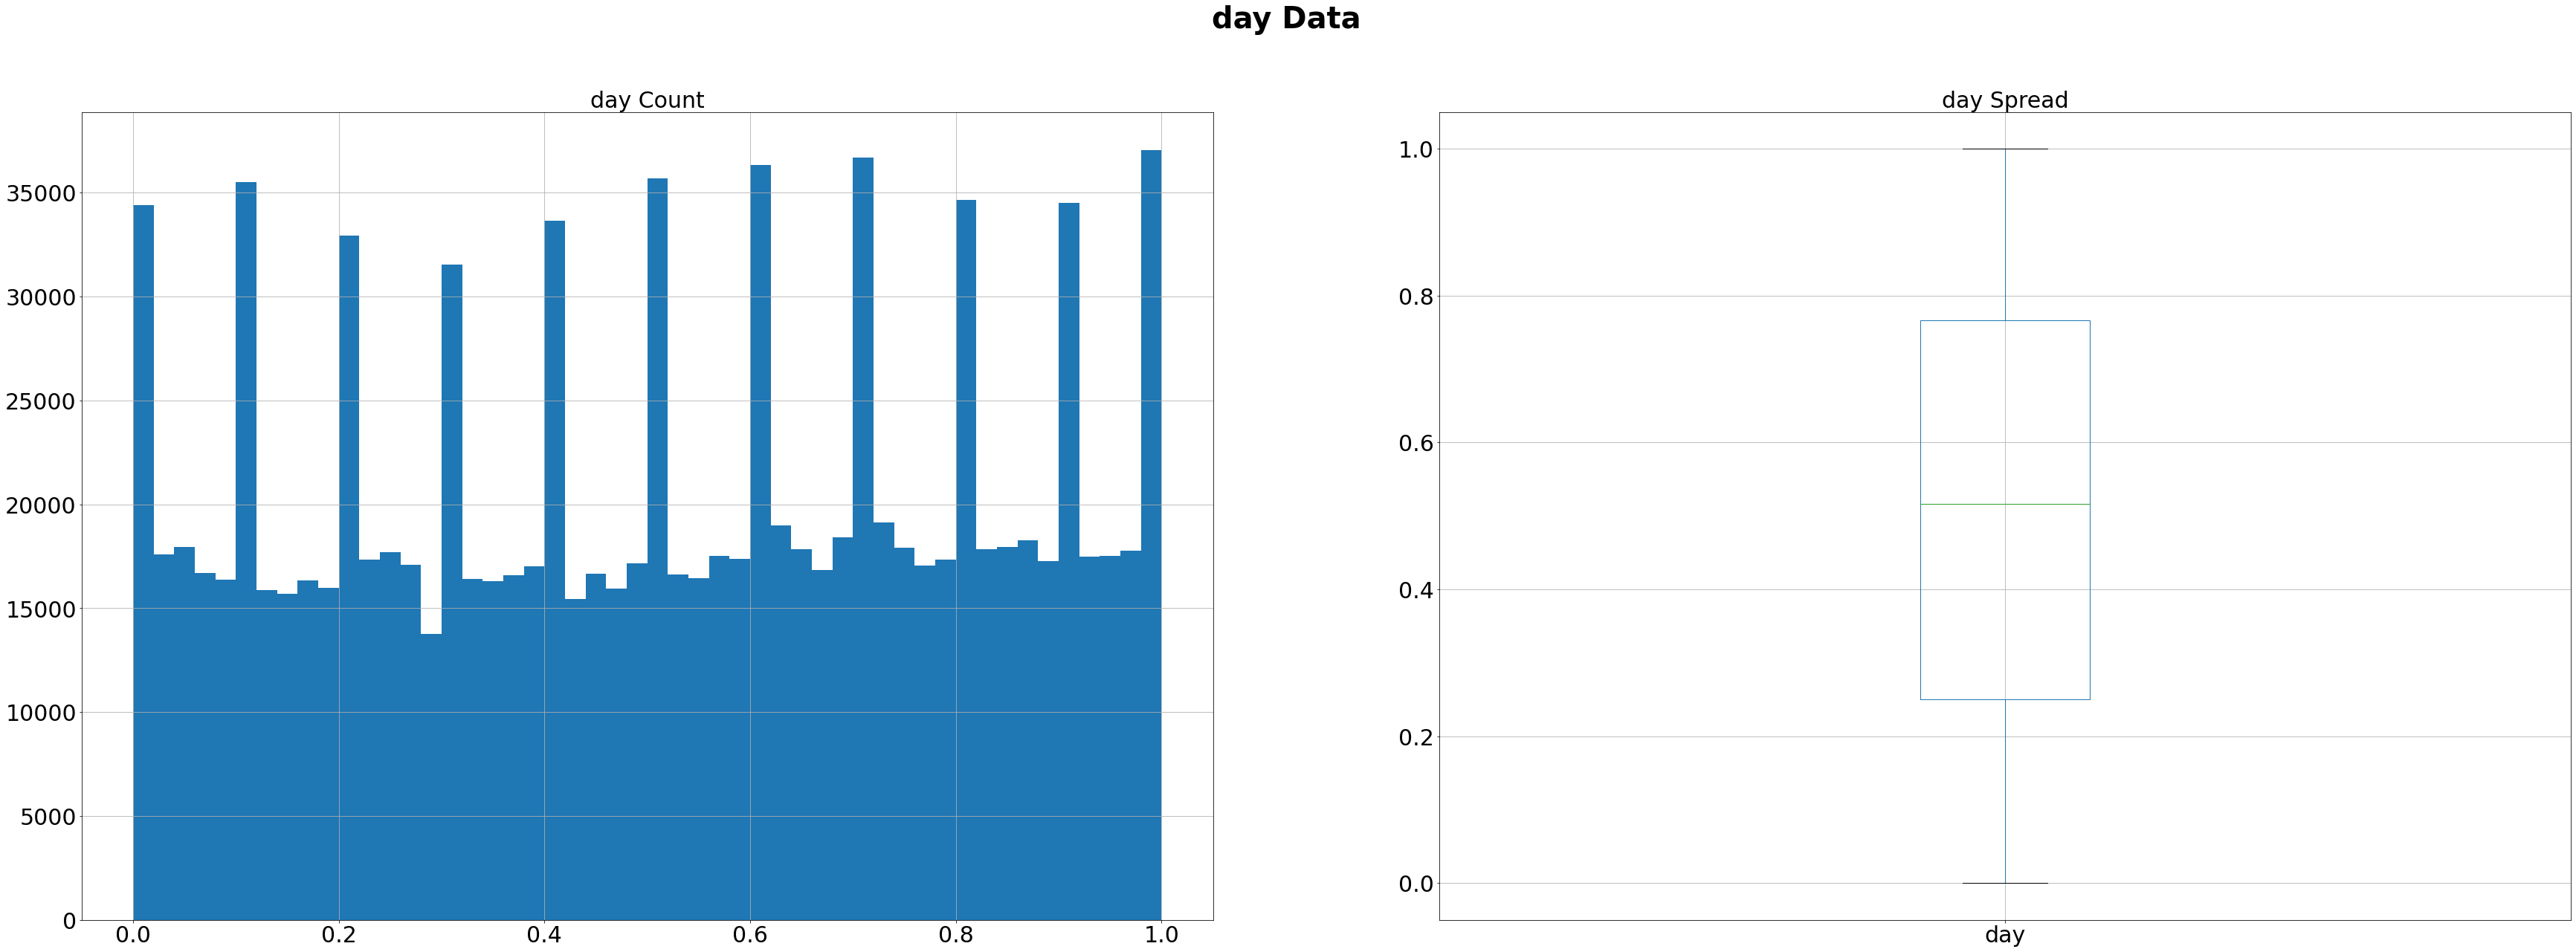

In [65]:
Normality_Check('day')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


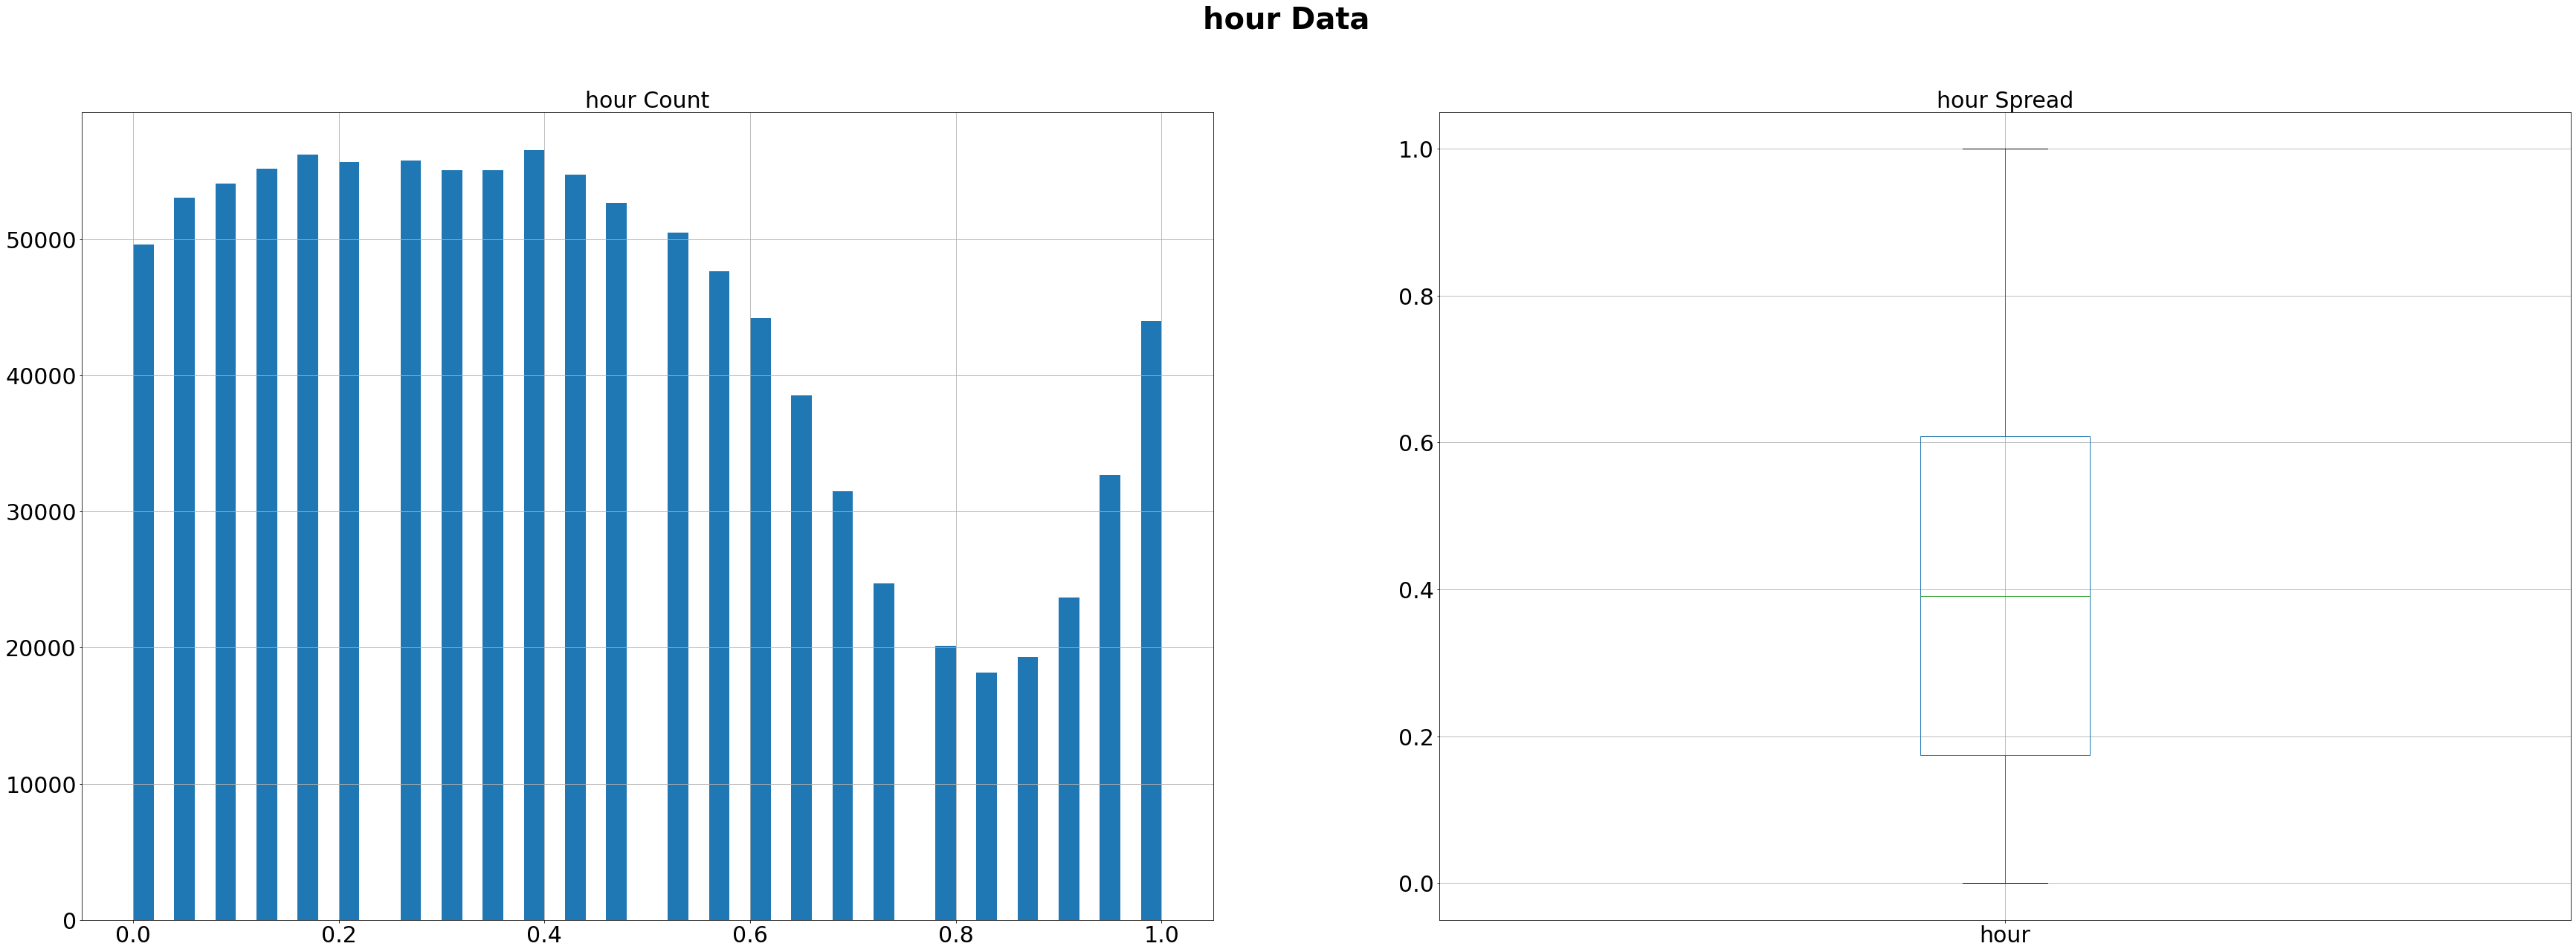

In [66]:
Normality_Check('hour')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


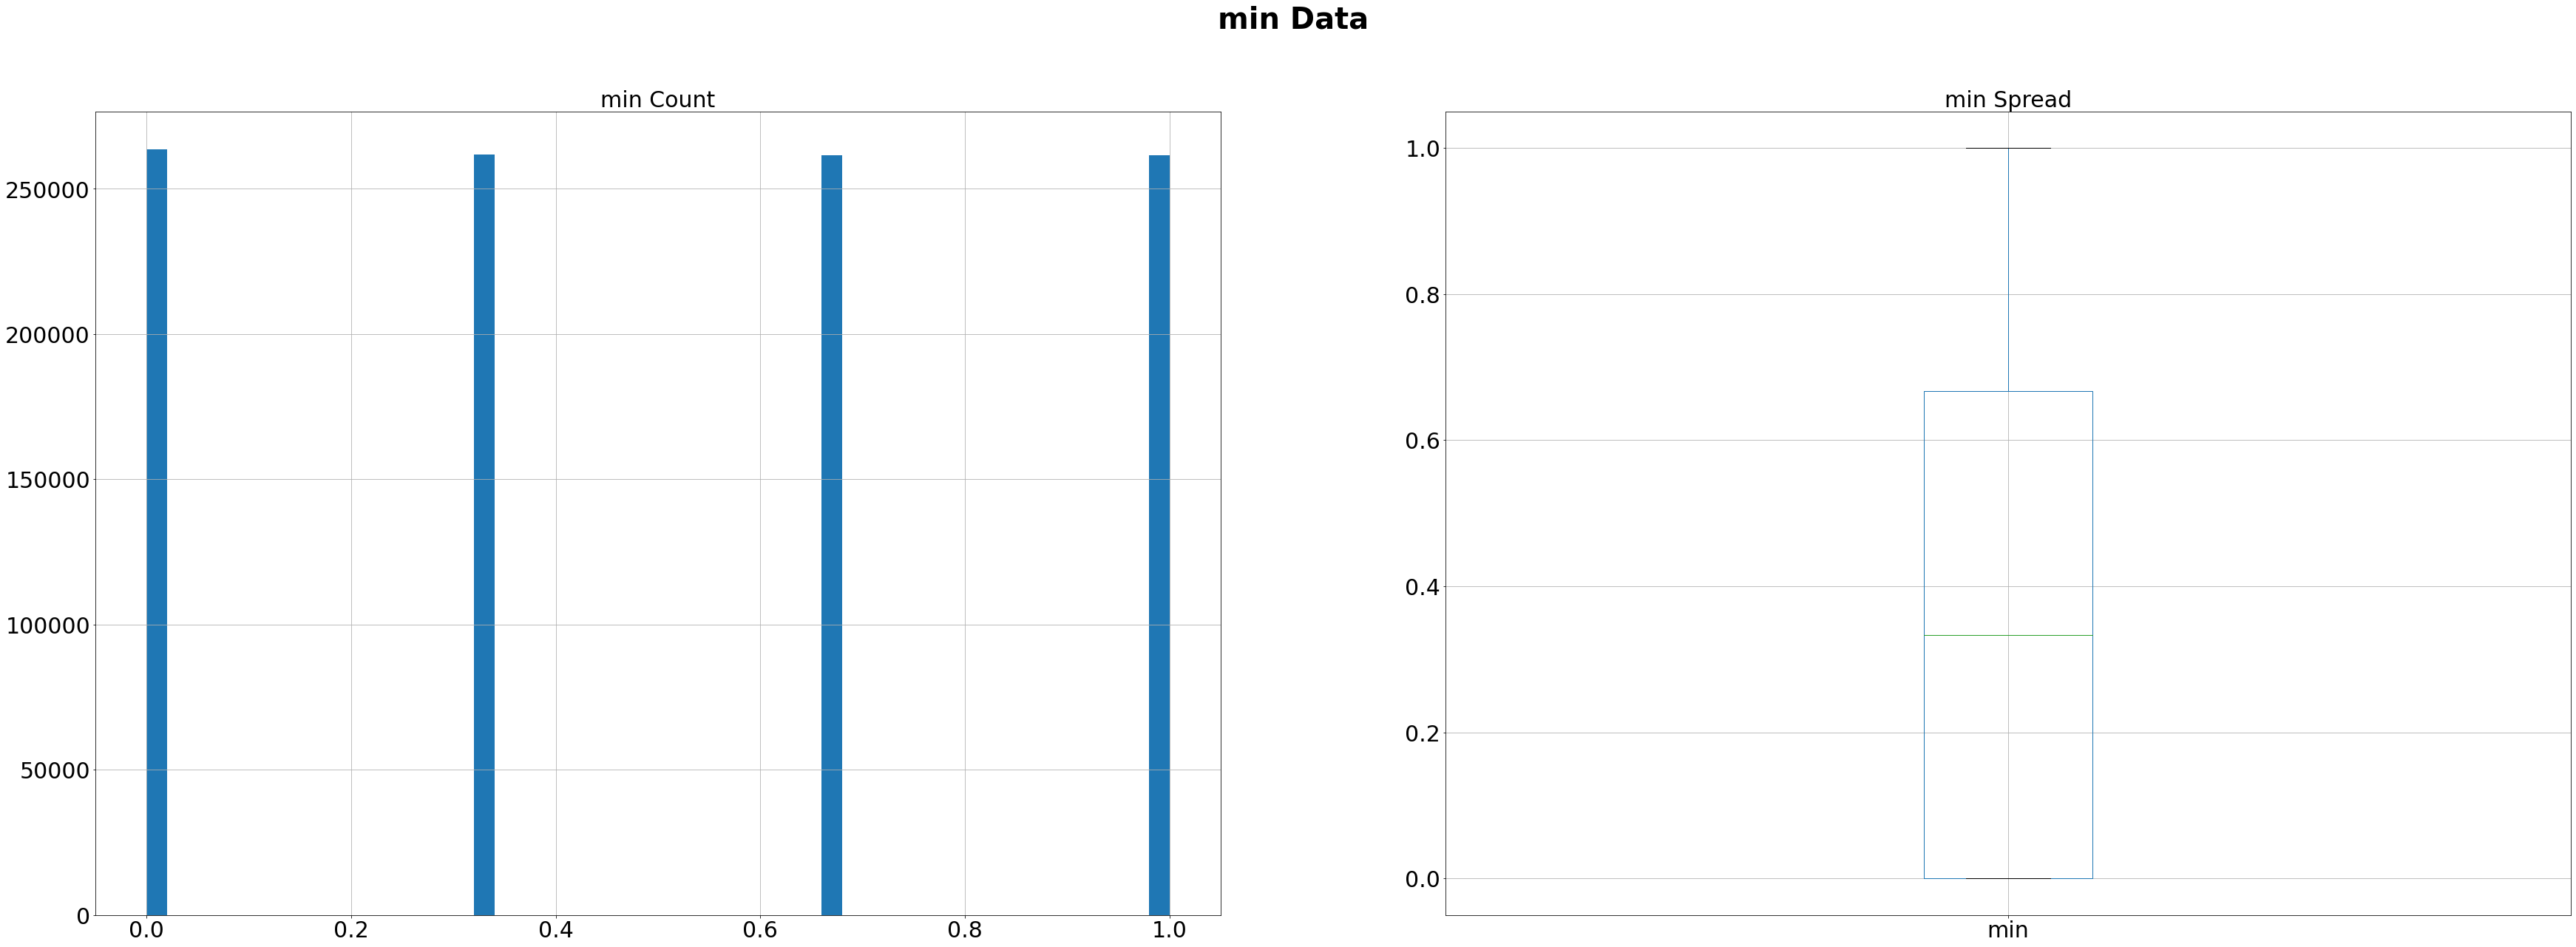

In [67]:
Normality_Check('min')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


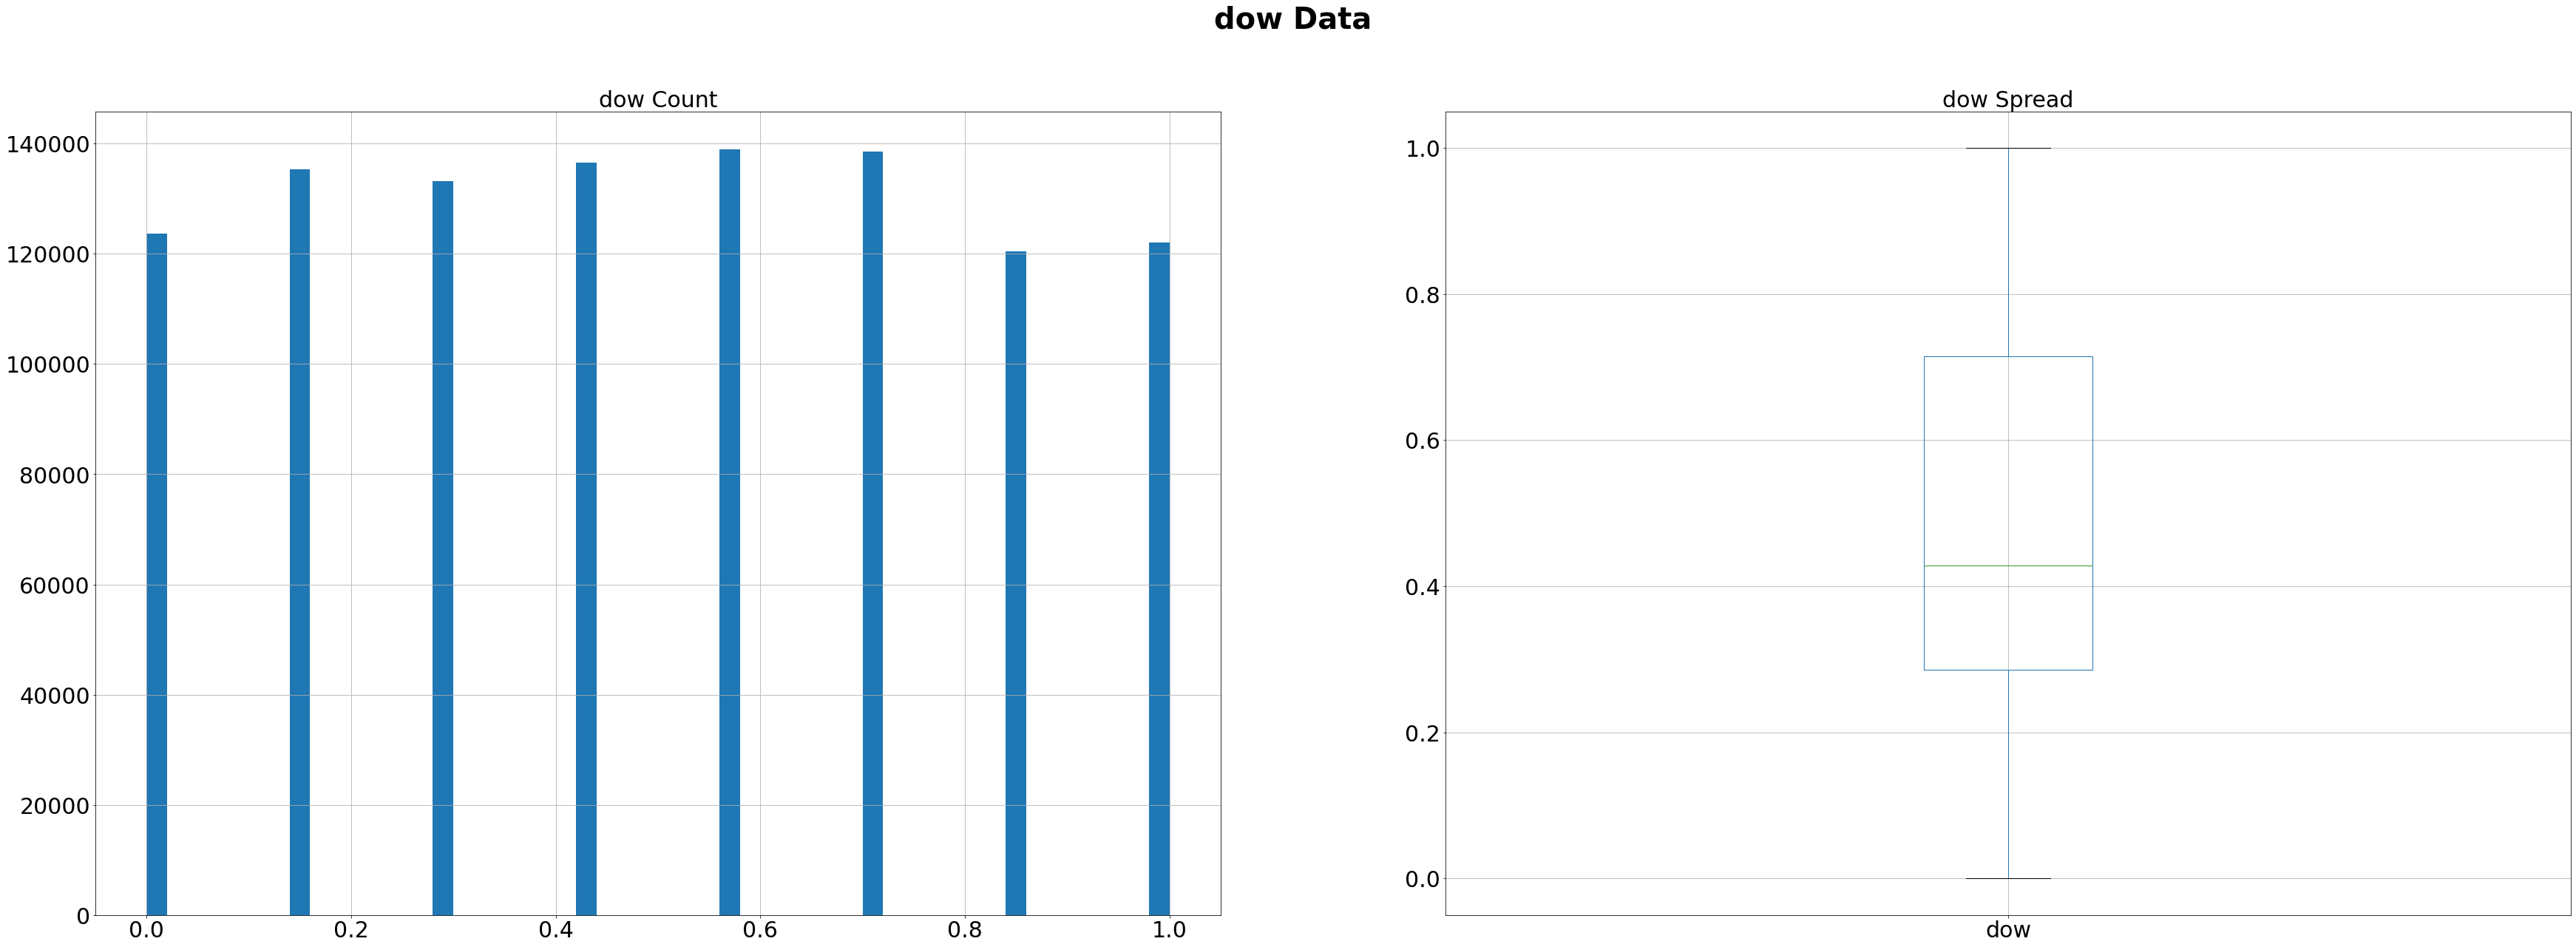

In [68]:
Normality_Check('dow')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


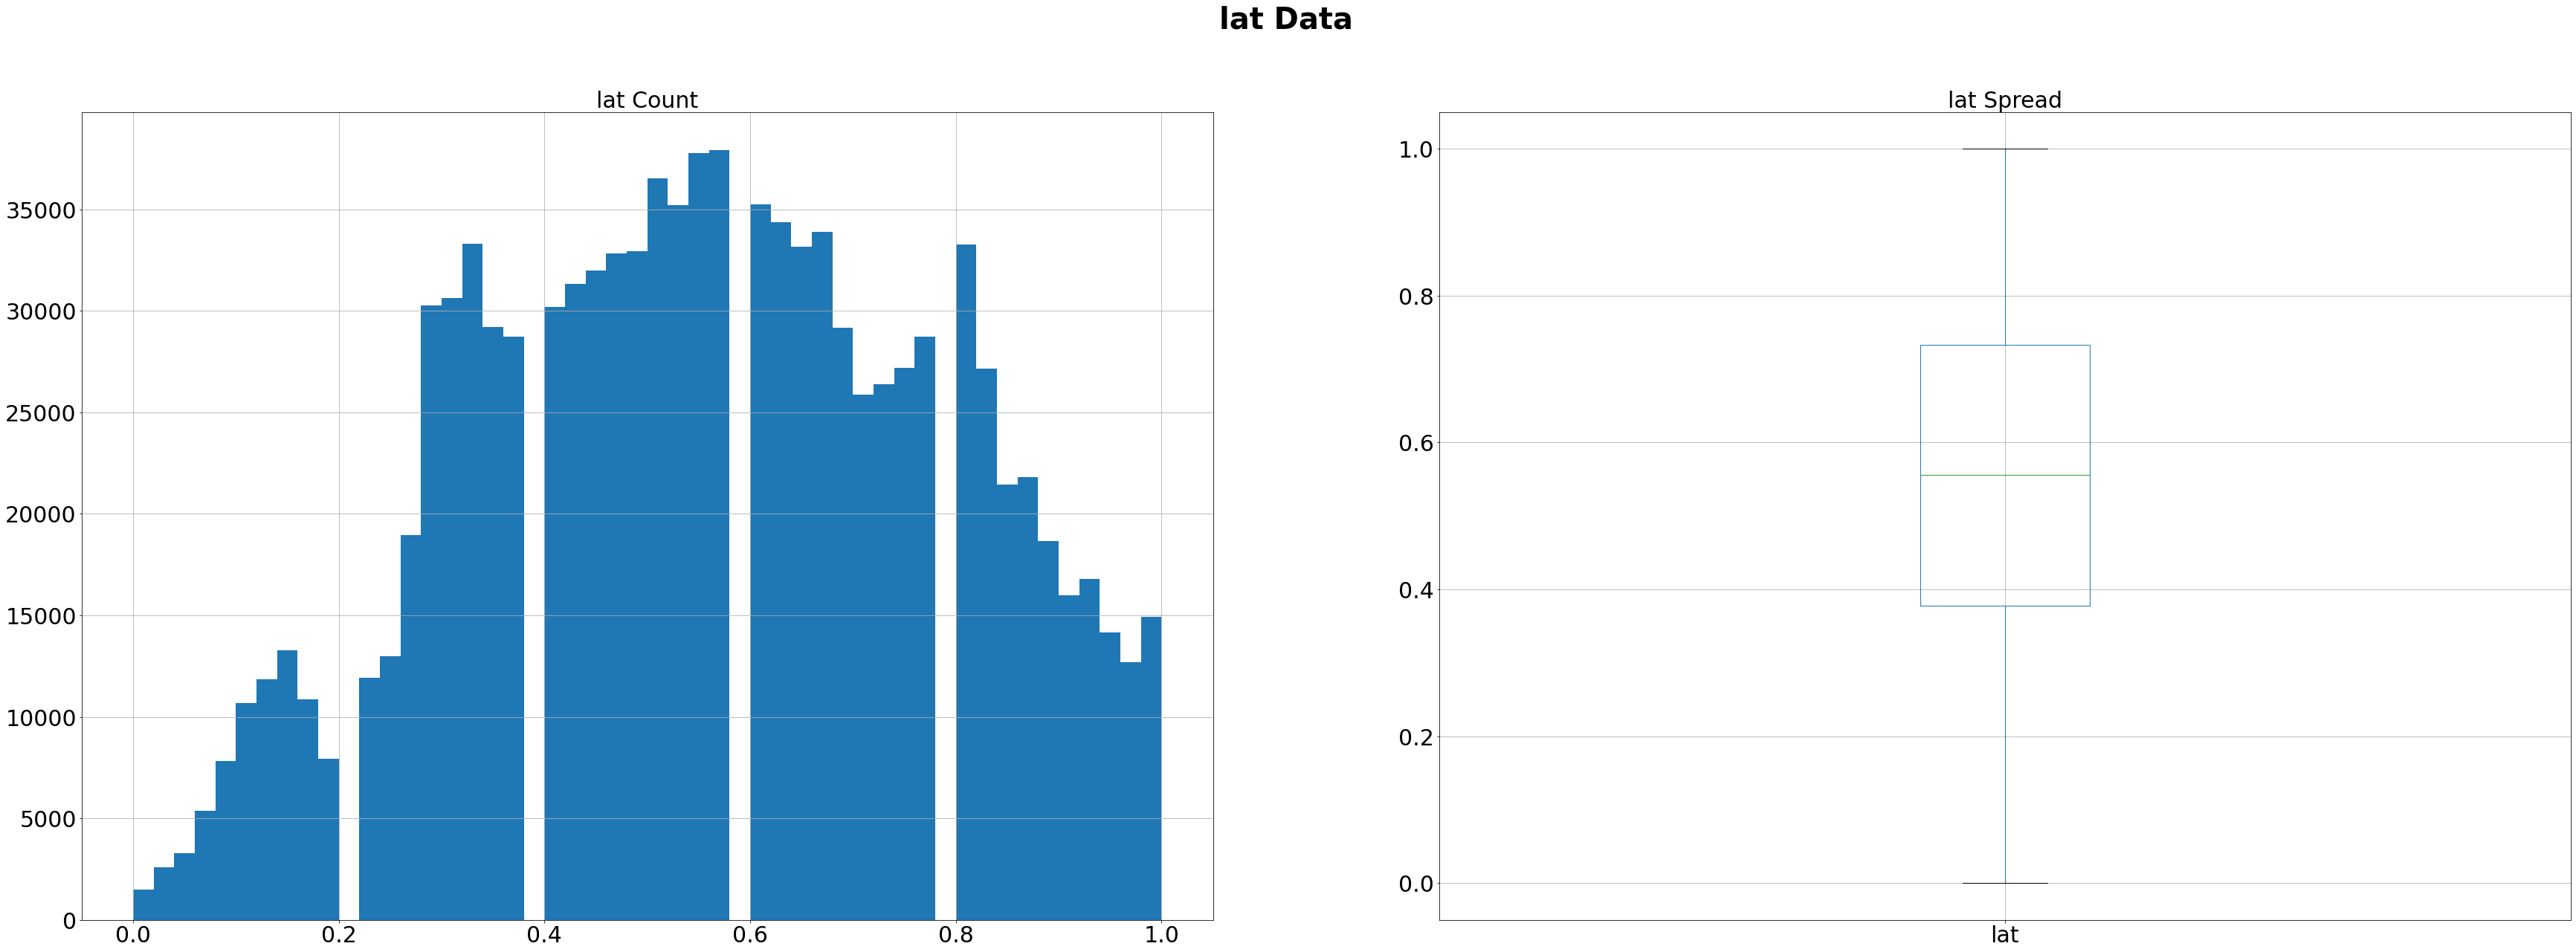

In [69]:
Normality_Check('lat')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


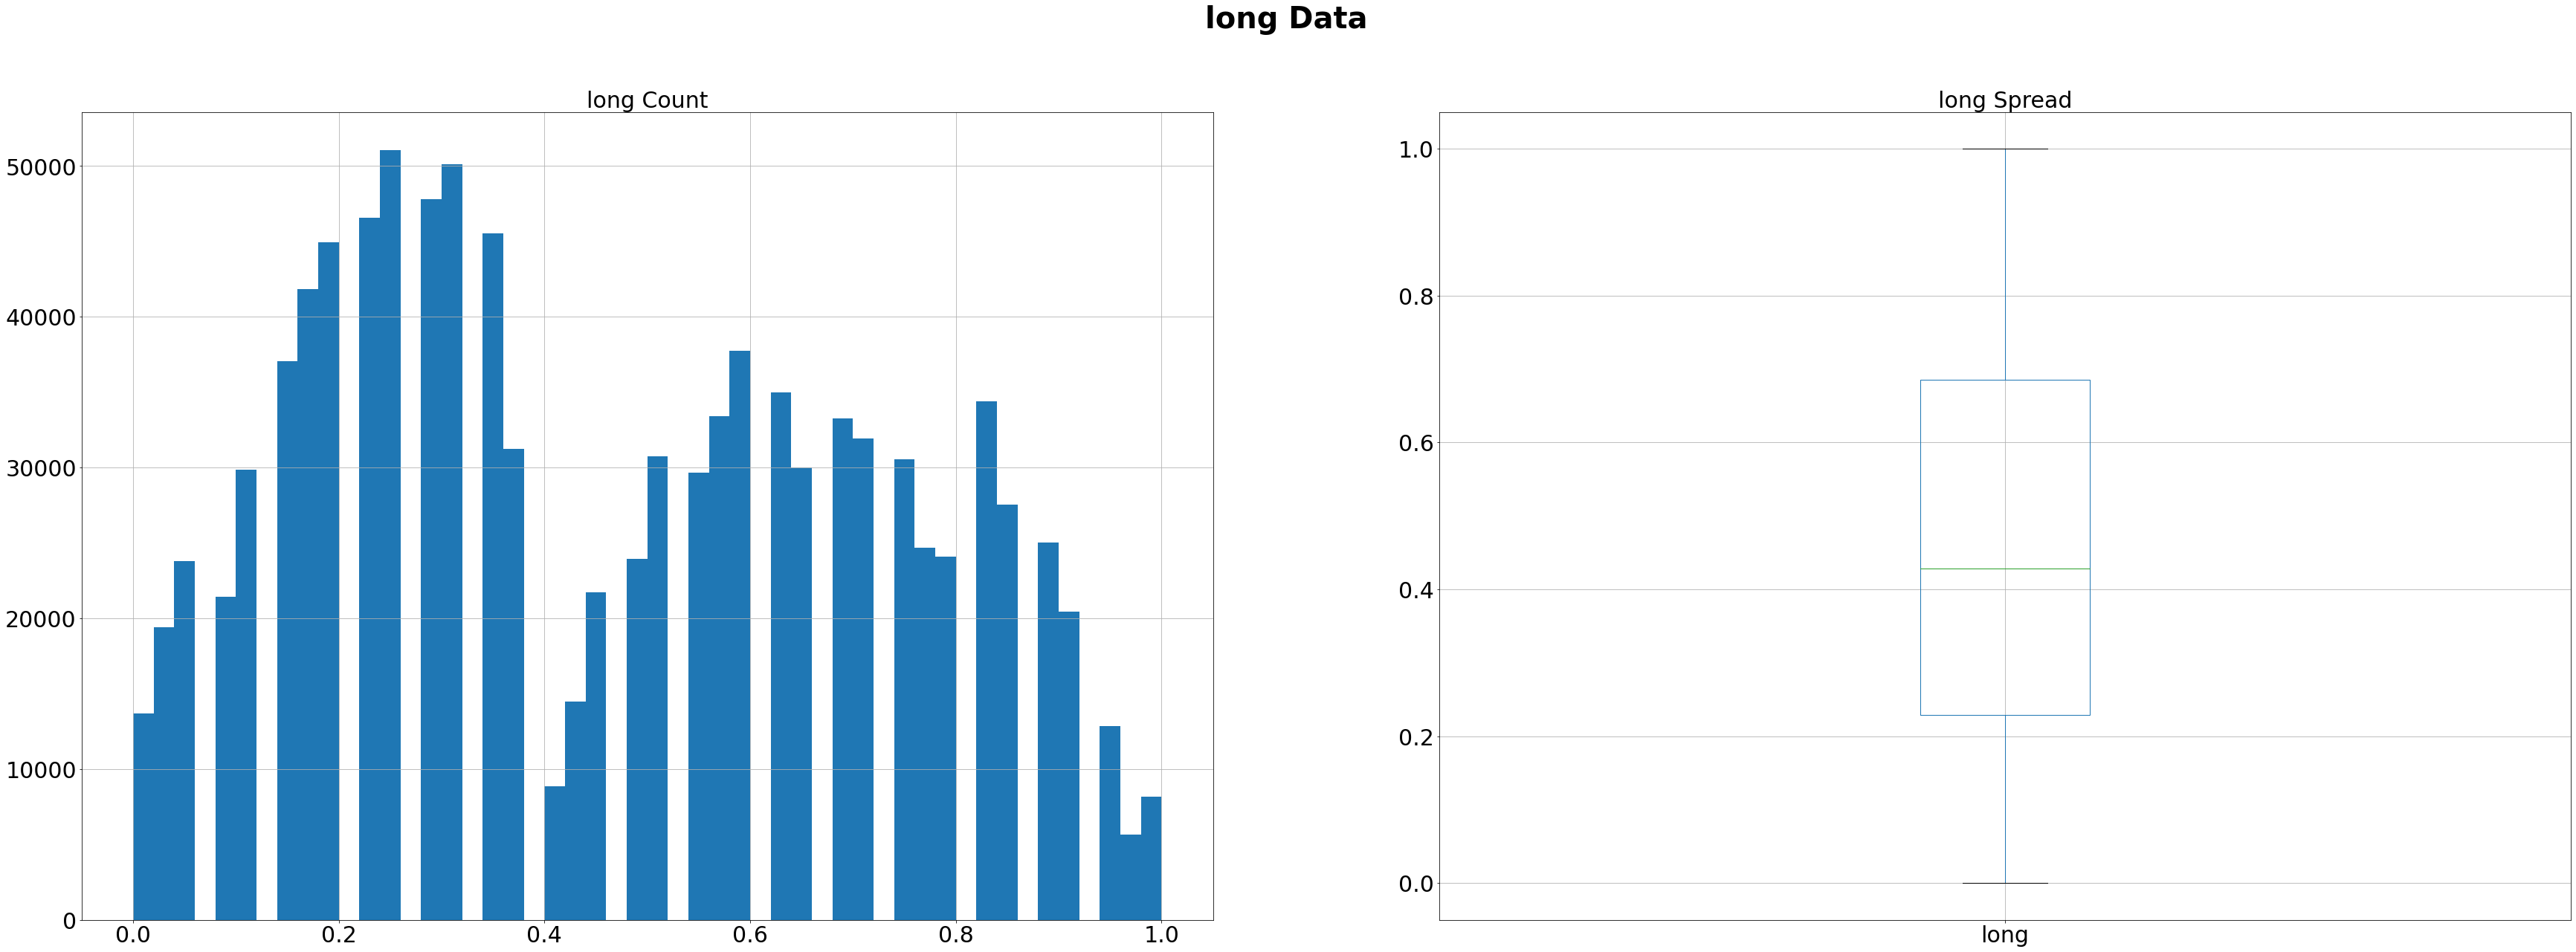

In [70]:
Normality_Check('long')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


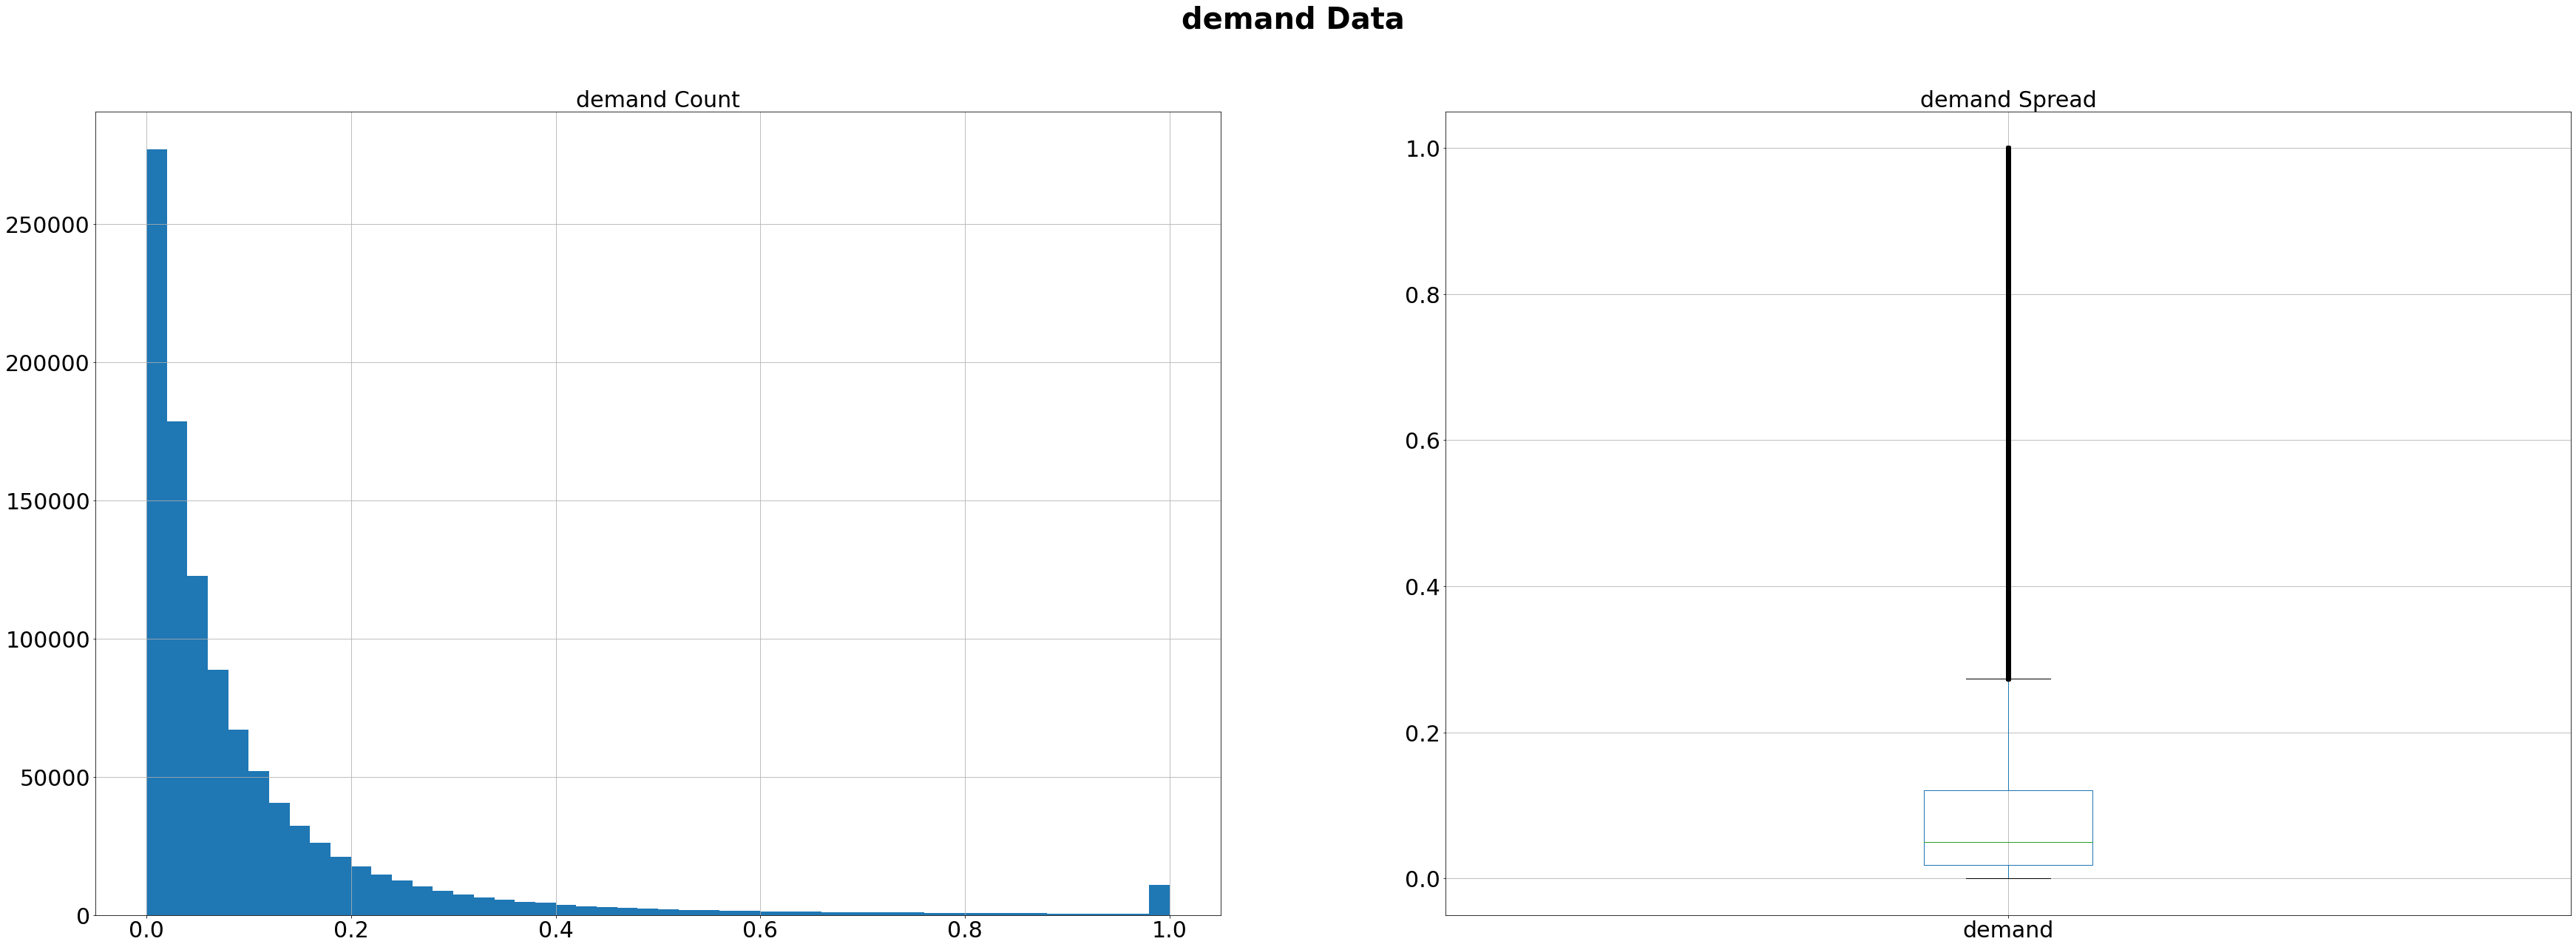

In [71]:
Normality_Check('demand')

One of the big challenges of this dataset is that it is imbalanced for the label data 'demand'.
Demand is heavily skewed to the left (see distribution above). Yet, traffic management is about being
ready for high demand on the roads so it is important that our model learns how to predict peak times well.

#### Create a new excel workbook

In [72]:
writer = pd.ExcelWriter('data/Dataset_sorted_feature.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='TrafficMgmt', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()
